In [1]:
import gdown
import zipfile
import os

# Download and extract dataset
file_url = "https://drive.google.com/uc?id=12MfYQpBl_79ak9K7VHx4jDEaeFUEhHEO"
output_zip = "spam.zip"
gdown.download(file_url, output_zip, quiet=False)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("spam_files")
os.remove(output_zip)

Downloading...
From: https://drive.google.com/uc?id=12MfYQpBl_79ak9K7VHx4jDEaeFUEhHEO
To: /content/spam.zip
100%|██████████| 3.58M/3.58M [00:00<00:00, 149MB/s]


In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/spam_files/url_spam_classification.csv')

In [3]:
#Converts the 'is_spam' column to binary values (0 and 1).
df['is_spam'] = df['is_spam'].apply(lambda x: 1 if x == df['is_spam'].unique()[0] else 0)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Creates a tokenizer for character-level tokenization and fits it on the URL data.
tokenizer = Tokenizer(char_level=True)  # Using character-level tokenization
tokenizer.fit_on_texts(df['url'])

In [6]:
#Converts the URLs to sequences of integers and pads them to ensure uniform length.
X = tokenizer.texts_to_sequences(df['url'])
X = pad_sequences(X, maxlen=100)  # Pad sequences to ensure uniform length

In [7]:
#Extracts the target variable.
y = df['is_spam']

In [9]:
from sklearn.model_selection import train_test_split

#Splits the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#Defines the model architecture:
  #Embedding layer for character-level input
  #GRU layer for sequence processing
  #Dense layers for classification

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=100),  # Embedding layer for character-level sequences
    GRU(128, return_sequences=False),  # GRU layer
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [11]:
#Prints a summary of the model architecture.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          8192      
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 115585 (451.50 KB)
Trainable params: 115585 (451.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
#Configures the model for training, specifying the optimizer, loss function, and metrics.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
#Sets up callbacks for early stopping and learning rate reduction during training.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

In [14]:
#Trains the model on the training data, using the specified callbacks.
history = model.fit(
    X_train, y_train, epochs=3, batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/3
7416/7416 [==============================] - 302s 41ms/step - loss: 0.5099 - accuracy: 0.7630 - val_loss: 0.4519 - val_accuracy: 0.8105 - lr: 1.0000e-05
Epoch 2/3
7416/7416 [==============================] - 310s 42ms/step - loss: 0.4245 - accuracy: 0.8109 - val_loss: 0.4132 - val_accuracy: 0.8056 - lr: 1.0000e-05
Epoch 3/3
7416/7416 [==============================] - 315s 42ms/step - loss: 0.3941 - accuracy: 0.8193 - val_loss: 0.3793 - val_accuracy: 0.8272 - lr: 1.0000e-05


In [15]:
#Evaluates the model on the test set and prints the results.
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

927/927 [==============================] - 14s 15ms/step - loss: 0.3793 - accuracy: 0.8272
Test Accuracy: 0.8272
Test Loss: 0.3793


In [16]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

927/927 [==============================] - 15s 15ms/step


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8272
Precision: 0.7230
Recall: 0.7370
F1 Score: 0.7299


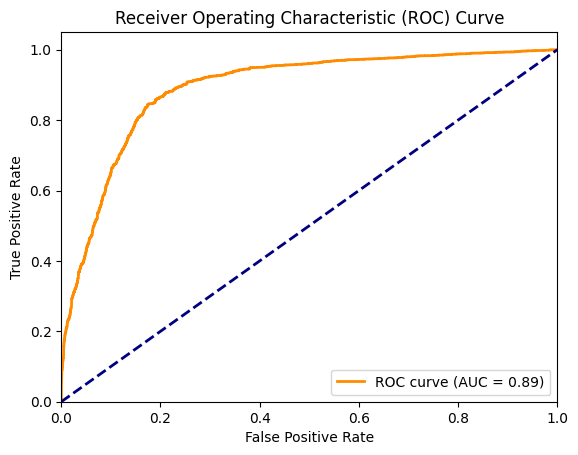

In [21]:
import matplotlib.pyplot as plt

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

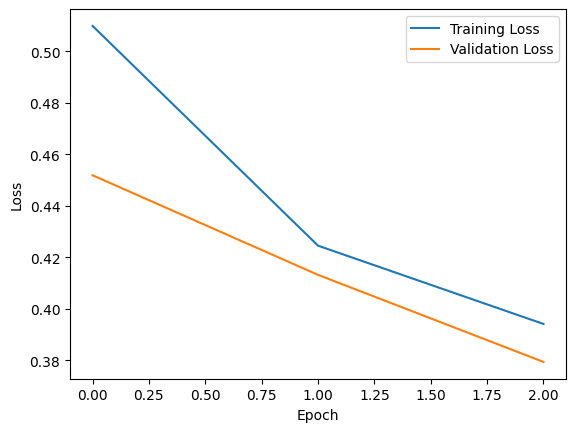

In [22]:
#Plots the training and validation loss over epochs.

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Creates a small test dataset with new URLs.
df_test = pd.DataFrame({
    'Link': [
        'https://briefingday.us8.list-manage.com/unsubs',
        'https://numlock.substack.com/subscribe',
        'https://briefingday.com/n/20200618/m#commentform'
    ],
    'Label': [1, 1, 0]
})

In [24]:
# Preprocesses the new test data.
X_test_new = tokenizer.texts_to_sequences(df_test['Link'])
X_test_new = pad_sequences(X_test_new, maxlen=100)

In [25]:
# Makes predictions on the new test data and adds them to the DataFrame.
predictions = (model.predict(X_test_new) > 0.7).astype(int)

df_test['Predicted'] = predictions
df_test['Prediction Probability'] = model.predict(X_test_new)

1/1 [==============================] - 0s 29ms/step


In [26]:
# Prints the prediction results for the new test data.
print("\nPrediction Results on New Data:")
print(df_test[['Link', 'Label', 'Predicted', 'Prediction Probability']])


Prediction Results on New Data:
                                               Link  Label  Predicted  \
0    https://briefingday.us8.list-manage.com/unsubs      1          1   
1            https://numlock.substack.com/subscribe      1          1   
2  https://briefingday.com/n/20200618/m#commentform      0          0   

   Prediction Probability  
0                0.914487  
1                0.909910  
2                0.124803  
